<a href="https://colab.research.google.com/github/FFI-Vietnam/camtrap-tools/blob/main/MegaDetector/confusion-matrix/04_create-visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
"""
This script evaluates recall accuracy of MegaDetector from a ground-truth dataset
and a result json file. Then it creates a set of visualization of recall values 
on each group of species.

After runnning this script, a 'results' folder is created

results
    |__ 
    
"""

"\nThis script evaluates recall accuracy of MegaDetector from a ground-truth dataset\nand a result json file. Then it creates a set of visualization of recall values \non each group of species.\n\nAfter runnning this script, a 'results' folder is created\n\nresults\n    |__ \n    \n"

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import requests
import os
from tqdm.notebook import tqdm

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# specifies Colab directories and file names
root = '/content/drive/'

dataset_folder = 'My Drive/FFI/MegaDetector Test/confusion-matrix/dataset'
contain_folder = 'My Drive/FFI/MegaDetector Test/confusion-matrix/data cleaning'
image_folder = 'My Drive/FFI/MegaDetector Test/confusion-matrix/visualization'

ground_truth_file_name = '01_ground-truth-table_Kon-Plong.csv'
MD_result_file_name = 'MegaDetector_result_2021-08-27.json'
# taxon match table is generated using Wildlife Insights/bulk-upload/04_collect-WI-taxon-database.ipynb script
# it is saved as 4.1_collect_WI-taxon-database.csv
taxon_match_table_file_name = '02_taxon-database-with-conservation-status.csv'
confusion_matrix_file_name = '03_confusion-matrix.csv'

In [61]:
# read and save file functions
def read_csv_Google_drive(root, contain_folder, file_name):
  file_path = os.path.join(root, contain_folder, file_name)
  return pd.read_csv(file_path)

def save_csv_Google_drive(df, root, contain_folder, file_name, index=False):
  """
  function to save a csv file to Google Drive
  param examples:
    root = '/content/drive/'
    contain_folder = 'My Drive/FFI/dataset'
    file_name = 'image_metadata(2020-06-26)_full.csv'
  """
  # save file to Colab runtime storage (will be deleted when this notebook is closed)
  df.to_csv('dataframe.csv', index=index)

  # save file back to Google Drive for permanent storage
  folder_path = os.path.join(root, contain_folder)
  file_path = os.path.join(root, contain_folder, file_name)
  try:
    os.makedirs(folder_path)
  except:
    pass

  with open('dataframe.csv', 'r') as f:
    df_file = f.read()

  with open(file_path, 'w') as f:
    f.write(df_file)

  print(f'File is saved to {file_name} in Google Drive at {file_path}')

def save_image_Google_drive(plt, root, contain_folder, file_name):
  """
  function to save an image file to Google Drive
  param examples:
    root = '/content/drive/'
    contain_folder = 'My Drive/FFI/dataset'
    file_name = 'MD_recall_all-species.jpg'
  """

  # save file back to Google Drive for permanent storage
  folder_path = os.path.join(root, contain_folder)
  file_path = os.path.join(root, contain_folder, file_name)
  try:
    os.makedirs(folder_path)
  except:
    pass

  plt.savefig(file_path)
  
  print(f'File is saved to {file_name} in Google Drive at {file_path}')

In [62]:
# read taxon_match_table
taxon_match_table = read_csv_Google_drive(root, contain_folder, taxon_match_table_file_name)
taxon_match_table.sample(5)

,id,class,order,family,genus,species,authority,commonNameEnglish,taxonomyType,uniqueIdentifier,FFI_species_name,conservation_status
19,2010433,Aves,Passeriformes,Pittidae,Hydrornis,cyaneus,"Blyth, 1843",Blue Pitta,biological,1e62cb8c-cd40-40ee-9d9d-ca91a80e104a,Blue Pitta,Least Concern
46,2014432,Aves,Passeriformes,Pellorneidae,Trichastoma,tickelli,"Blyth, 1859",Buff-breasted Babbler,biological,bad6ab4c-cedb-4cf9-8a78-d6e6d20c97d9,Buff-breasted Babbler,Least Concern
108,2014445,Aves,Passeriformes,Pellorneidae,Turdinus,brevicaudatus,"Blyth, 1855",Streaked Wren-babbler,biological,169ed977-68c0-4685-a5e9-9ddbc90b6997,Streaked Wren-babbler,Least Concern
63,2005224,Mammalia,Cetartiodactyla,Suidae,Sus,scrofa,"Linnaeus, 1758",Wild Boar,biological,d372cda5-a8ca-4b7b-97ed-4e4fab9c9b4b,Wild Boar,Least Concern
57,2010430,Aves,Passeriformes,Pittidae,Hydrornis,soror,"Wardlaw-Ramsay, 1881",Blue-rumped Pitta,biological,c7939461-118f-4b63-8ae4-38071dbcf892,Blue-rumped Pitta,Least Concern


In [63]:
# read confusion matrix
confusion_matrix = read_csv_Google_drive(root, contain_folder, confusion_matrix_file_name)
confusion_matrix.set_index('Unnamed: 0', inplace=True)
confusion_matrix = confusion_matrix.T
confusion_matrix

Unnamed: 0,Animal,Annamite Dark Muntjac,Asian Barred Owlet,Asian Black Bear,Asian Palm Civet,Asian Red-cheeked Squirrel,Asian Small-clawed Otter,Asian Stubtail,Asian Water Monitor,Asiatic Brush-tailed Porcupine,Banded Kingfisher,Banded Krait,Bar-backed Partridge,Bar-bellied Pitta,Barred Cuckoo-dove,Bird,Black Giant Squirrel,Black-hooded Laughingthrush,Black-throated Laughingthrush,Blank,Blue Pitta,Blue Whistling-thrush,Blue-rumped Pitta,Bronzed Drongo,Brown Fish-owl,Brownish-flanked Bush Warbler,Buff-breasted Babbler,Chestnut-eared Laughingthrush,Chinese Blackbird,Chinese Serow,Coral-billed Scimitar-babbler,Crab-eating Mongoose,Crested Argus,Crested Goshawk,Crested Serpent Eagle,Crow-billed Drongo,Domestic Dog,Domestic Pig,Domestic Water Buffalo,Eastern Crowned Warbler,...,Reptile,Rhesus Macaque,Rufous Woodpecker,Rufous-tailed Robin,Rufous-throated Partridge,Rusty-naped Pitta,Sambar,Scaly Thrush,Shrew,Siamese Fireback,Siberian Blue Robin,Siberian Rubythroat,Siberian Thrush,Silver Pheasant,Slaty-blue Flycatcher,Slaty-legged Crake,Small Indian Civet,Small Niltava,Snake,Snowy-browed Flycatcher,Spotted Linsang,Spotted Owlet,Squirrel,Streak-breasted Scimitar-babbler,Streaked Wren-babbler,Stump-tailed Macaque,Sunda Pangolin,Tickell's Blue Flycatcher,White-cheeked Laughingthrush,White-crowned Forktail,White-gorgeted Flycatcher,White-rumped Shama,White-tailed Blue Robin,White-tailed Flycatcher,White-throated Fantail,White-winged Magpie,Wild Boar,Yellow-bellied Weasel,Yellow-throated Marten,All
Animal,28.00,77.00,6.00,10.00,144.00,310.00,8.00,1.00,0.0,69.00,1.0,2.0,10.00,82.00,3.0,122.00,5.00,253.00,1.0,5849.00,78.00,127.00,178.00,4.00,27.00,0.0,5.0,29.00,2.0,29.00,2.00,202.0,100.00,1.0,27.00,4.0,51.0,3.0,70.00,0.0,...,1.00,39.00,1.0,69.00,134.00,82.00,4.0,113.00,3.00,41.00,12.00,30.00,7.00,113.00,1.0,156.0,2.00,0.0,1.00,0.0,22.00,3.00,227.0,9.0,0.0,268.00,5.0,1.0,2.0,3.0,44.00,12.00,2.0,11.00,9.00,16.00,29.00,13.00,31.00,17024.0
Human,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,2.00,0.00,3.00,0.0,763.00,0.00,8.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,1.0,0.00,0.0,0.00,0.0,14.0,0.0,0.00,0.0,...,0.00,0.00,0.0,1.00,0.00,0.00,0.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,4.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1997.0
Blank,158.00,10.00,13.00,5.00,24.00,231.00,3.00,3.00,1.0,82.00,0.0,3.0,17.00,47.00,0.0,336.00,1.00,126.00,0.0,55430.00,30.00,61.00,113.00,2.00,1.00,2.0,20.0,15.00,0.0,6.00,4.00,50.0,9.00,1.0,6.00,1.0,8.0,0.0,11.00,1.0,...,2.00,27.00,1.0,84.00,65.00,38.00,0.0,140.00,11.00,7.00,7.00,24.00,1.00,17.00,0.0,159.0,4.00,6.0,12.00,2.0,31.00,1.00,535.0,9.0,1.0,94.00,0.0,0.0,0.0,0.0,77.00,9.00,0.0,3.00,3.00,8.00,14.00,10.00,5.00,66415.0
Total,187.00,87.00,19.00,15.00,168.00,541.00,11.00,4.00,1.0,151.00,1.0,5.0,27.00,129.00,3.0,460.00,6.00,382.00,1.0,62042.00,108.00,196.00,291.00,6.00,28.00,2.0,25.0,44.00,2.0,35.00,6.00,253.0,109.00,2.0,33.00,5.0,73.0,3.0,81.00,1.0,...,3.00,66.00,2.0,154.00,199.00,120.00,4.0,254.00,14.00,48.00,19.00,54.00,8.00,130.00,1.0,315.0,6.00,6.0,13.00,2.0,53.00,4.00,766.0,18.0,1.0,362.00,5.0,1.0,2.0,3.0,121.00,21.00,2.0,14.00,12.00,24.00,43.00,23.00,36.00,85436.0
Recall,0.15,0.89,0.32,0.67,0.86,0.57,0.73,0.25,0.0,0.46,1.0,0.4,0.37,0.64,1.0,0.27,0.83,0.66,1.0,0.89,0.72,0.65,0.61,0.67,0.96,0.0,0.2,0.66,1.0,0.83,0.33,0.8,0.92,0.5,0.82,0.8,0.7,1.0,0.86,0.0,...,0.33,0.59,0.5,0.45,0.67,0.68,1.0,0.44,0.21,0.85,0.63,0.56,0.88,0.87,1.0,0.5,0.33,0.0,0.08,0.0,0.42,0.75,0.3,0.5,0.0,0.74,1.0,1.0,1.0,1.0,0.36,0.57,1.0,0.79,0.75,0.67,0.67,0.57,0.86,0.2


In [64]:
# read MegaDetector result
result_path = os.path.join(root, dataset_folder, MD_result_file_name)
with open(result_path) as f:
  mega_result = json.load(f)

# print sample result
mega_result['images'][5]

{'detections': [{'bbox': [0.5825, 0.9118, 0.4078, 0.08803],
   'category': '1',
   'conf': 0.849},
  {'bbox': [0.003062, 0.8421, 0.1527, 0.1578],
   'category': '1',
   'conf': 0.214}],
 'file': '/content/drive/My Drive/Camera Trap Data/Kon Plong/2019-2020 Survey/Processed images/Final/100/67096/100__67096__2019-04-27__12-50-26(3).JPG',
 'max_detection_conf': 0.849}

In [65]:
def get_taxonomy(taxon_match_table, species_common_name, level):
  """
  get taxonomical class level of a species
  """
  row = taxon_match_table[taxon_match_table['FFI_species_name'] == species_common_name]
  try:
    taxon_class = row[level.lower()].iat[0]
  except:
    print('     Can not find taxonomy info for', species_common_name)
  return taxon_class

# test
get_taxonomy(taxon_match_table, 'Annamite Dark Muntjac', 'family')

'Cervidae'

In [66]:
def find_FFI_species_by_taxonomy(taxon_match_table, level, taxonomy):
  """
  returns list of species in a taxonomical group, e.g. class Mammalia, order Rodentia
  """
  sub_df = taxon_match_table[taxon_match_table[level.lower()] == taxonomy]
  
  return sub_df['FFI_species_name'].to_list() 

In [67]:
def create_confusion_matrix_by_group(taxon_match_table, confusion_matrix, species_group):
  """
  create a confusion matrix by species group, e.g. "ungulates", "small carnivores", "birds", "small mammals (squirrels and rats)", "primates"
  @params species_group: dict {group_common_name: [taxonomical_level, group_scientific_name, except]}
    example: {"Birds":["class", "Aves", []], -> all Birds
              "Small carnivores":["order", "Carnivora", ["Asian Black Bear"]]} -> all carnivores excepts for Bears
  """
  confusion_matrix_by_group = pd.DataFrame(index = ['Animal', 'Human', 'Blank', 'Total', 'Recall'])
  for group in species_group.keys():
    species_list = find_FFI_species_by_taxonomy(taxon_match_table, 
                                                species_group[group][0], 
                                                species_group[group][1])
    # remove except species, e.g. Asian Black Bear not in Small Carnivores
    species_list = list(set(species_list) - set(species_group[group][2]))
    # remove unnecessary species such as Bat, Maxomys, etc
    species_list = list(set(species_list) & set(confusion_matrix.columns))
    # lump into one group
    confusion_matrix_by_group[group] = confusion_matrix[species_list].astype('float').sum(axis = 1)

  # update recall
  for col in confusion_matrix_by_group.columns:
    if col == 'Human':
      confusion_matrix_by_group[col][4] = round(int(confusion_matrix_by_group[col][1]) / int(confusion_matrix_by_group[col][3]), 2)
    else:
      confusion_matrix_by_group[col][4] = round(int(confusion_matrix_by_group[col][0]) / int(confusion_matrix_by_group[col][3]), 2)
  return confusion_matrix_by_group


In [68]:
def create_confusion_matrix_by_conservation_status(taxon_match_table, confusion_matrix, conservation_status):
  """
  create a confusion matrix by conservation status
  @params conservation_status: list of status
    example: ["Endangered", "Vulnerable"]
  """
  def status_of(species):
    return taxon_match_table[taxon_match_table['FFI_species_name'] == species]['conservation_status'].iat[0]
  
  confusion_matrix_by_conservation_status = pd.DataFrame(index = ['Animal', 'Human', 'Blank', 'Total', 'Recall'])
  for species in confusion_matrix.columns:
    try: # avoid unrecorded species such as Banded Krait
      if status_of(species) in conservation_status:
        confusion_matrix_by_conservation_status[species] = confusion_matrix[species]
    except:
      pass
  return confusion_matrix_by_conservation_status

In [69]:
def create_confusion_matrix_in_group(taxon_match_table, confusion_matrix, species_group):
  """
  create a confusion matrix in each species group, e.g. "ungulates", "small carnivores", "birds", "small mammals (squirrels and rats)", "primates"
  @params species_group: list [group_common_name, taxonomical_level, group_scientific_name, except]
    example: + ["Birds", "class", "Aves", []] -> for all Birds
             + ["Small carnivores", "order", "Carnivora", ["Asian Black Bear"]]} -> for all carnivores excepts for Bears
  """
  confusion_matrix_in_group = pd.DataFrame(index = ['Animal', 'Human', 'Blank', 'Total', 'Recall'])
  species_list = find_FFI_species_by_taxonomy(taxon_match_table, 
                                              species_group[1], 
                                              species_group[2])
  # remove except species, e.g. Asian Black Bear not in Small Carnivores
  species_list = list(set(species_list) - set(species_group[3]))
  # remove unnecessary species such as Bat, Maxomys, etc
  species_list = list(set(species_list) & set(confusion_matrix.columns))
  # get columns by species
  confusion_matrix_in_group = confusion_matrix[species_list].astype('float')

  # update recall
  for col in confusion_matrix_in_group.columns:
    if col == 'Human':
      confusion_matrix_in_group[col][4] = round(int(confusion_matrix_in_group[col][1]) / int(confusion_matrix_in_group[col][3]), 2)
    else:
      confusion_matrix_in_group[col][4] = round(int(confusion_matrix_in_group[col][0]) / int(confusion_matrix_in_group[col][3]), 2)
  return confusion_matrix_in_group

In [70]:
def visualize_recall_bargraph(group_name, confusion_matrix, threshold, color_dict, num_image_threshold=0, legend_by_color=False, custom_size=None, save_fig=False):
  """
  visualize recall values by bargraph by taxonomical class
  """

  print(f"Generating visualization plot for {group_name}...")
  total = []
  recall = []
  names = []
  colors = []

  image_count = len(mega_result['images'])

  species_list = confusion_matrix.columns.to_list()
  for species in species_list:
    if species not in ['All']:
      if confusion_matrix[species]['Total'] >= num_image_threshold:
        colors.append(color_dict[species])
        recall.append(confusion_matrix[species]['Recall'])
        total.append(confusion_matrix[species]['Total'])
        names.append((species))

  # create df to sort recall values
  recall_stats = pd.DataFrame({'name':names, 'recall':recall, 'total':total, 'colors':colors})
  recall_stats['recall'] = recall_stats['recall'].astype('float')
  recall_stats['total'] = recall_stats['total'].astype('int')
  recall_stats.sort_values('recall', inplace=True, ascending=True)

  # creating the bar plot
  species_name = recall_stats['name'].to_list()
  values = recall_stats['recall'].to_list()
  total = recall_stats['total'].to_list()
  colors = recall_stats['colors'].to_list()
  avg_recall = np.mean(recall_stats['recall'])

  if custom_size:
    fig = plt.figure(figsize=custom_size)
    
  plt.barh(species_name, values, color=colors)
  for i, v in enumerate(values):
    recall_value_text_location = v
    plt.text(recall_value_text_location, i, str(round(v,2)), color='blue', fontweight='bold')
    if not custom_size:
      num_image_text_location = v + 0.09
    else:
      num_image_text_location = v + 1/(1.5*custom_size[0])
    plt.text(num_image_text_location, i, f'{str(total[i])} images', color='blue', fontweight='bold')
  # for i, v in enumerate(total):

  plt.xlabel("Values")
  plt.ylabel("Species name")
  labels = list(color_map.keys())
  if legend_by_color:
    handles = [plt.Rectangle((0,0),1,1, color=color_map[label]) for label in labels]
    plt.legend(handles, labels)
  plt.title(f"Evaluate over {image_count} images for {group_name}" +
            f"\nminimum image amount: {num_image_threshold}" +
            f"\nthreshold:  {threshold}" +
            f"\naverage_recall_value: {round(avg_recall,2)}")
  if save_fig:
    save_image_Google_drive(plt, root, image_folder, save_fig)
  plt.show()


Text(0.5, 1.0, 'Recall histogram\nMinimum image amount: 20 \nMegaDetector threshold: 0.5')

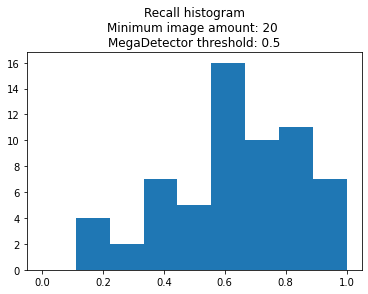

In [71]:
# create frequency graph
plt.hist(confusion_matrix.loc['Recall'][confusion_matrix.loc['Total'] > 20],
         bins=np.linspace(0,1,10))
plt.title(
          'Recall histogram\n' + 
          'Minimum image amount: 20 \n' +
          'MegaDetector threshold: 0.5'
          )


In [72]:
# map color with conservation status
colors = {}
color_map = {
              "Not Evaluated": "lightblue",
              "Data Deficient": "lightyellow",
              "Least Concern": "mediumseagreen",
              "Near Threatened": "olive",
              "Vulnerable": "orange",
              "Endangered": "orangered",
              "Critically Endangered": "maroon",
              "Extinct in the Wild": "black",
              "Extinct": "dimgrey",
              "Not Applicable": "lightgrey"
            }
for name in confusion_matrix.columns:
  try: # for unrecorded species such as Banded Krait
    status = taxon_match_table[taxon_match_table['FFI_species_name'] == name]['conservation_status'].iat[0]
    colors[name] = color_map[status]
  except:
    pass

Generating visualization plot for All species...
File is saved to by independent event/MD_recall_Kon-Plong_all-species_min-20-images.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/MD_recall_Kon-Plong_all-species_min-20-images.jpg


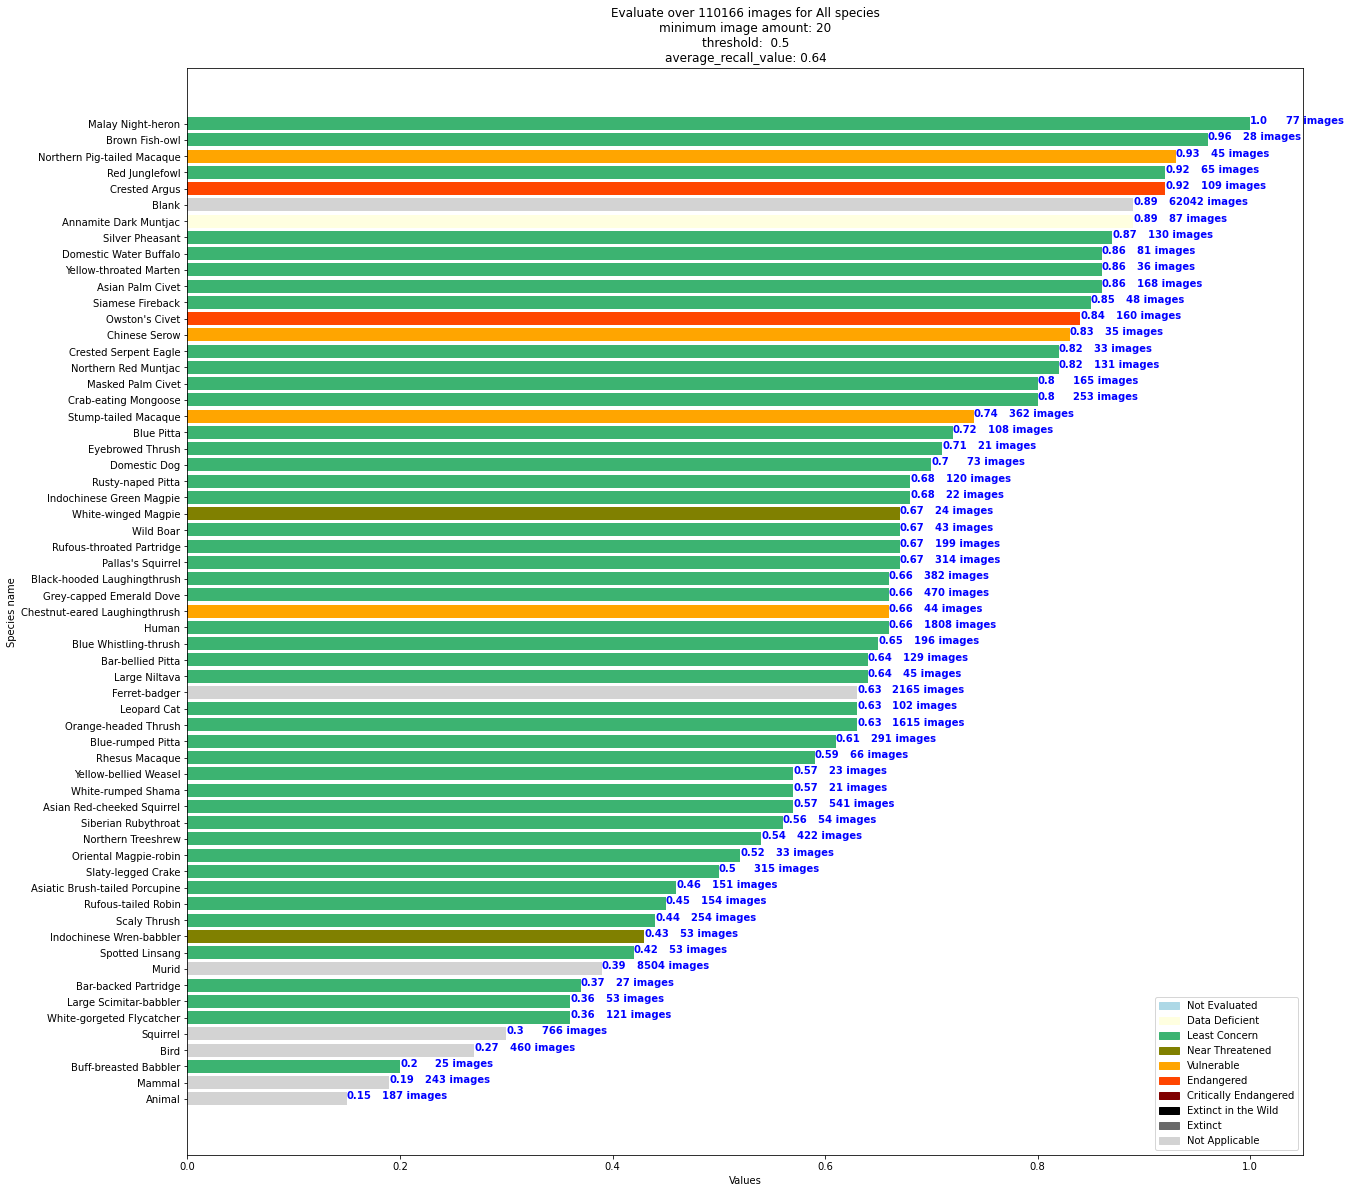

In [73]:
# draw bar graph
visualize_recall_bargraph('All species', 
                          confusion_matrix, 
                          threshold=0.5, 
                          color_dict = colors, 
                          num_image_threshold=20, 
                          legend_by_color=True, 
                          custom_size=(20,20),
                          save_fig="by independent event/MD_recall_Kon-Plong_all-species_min-20-images.jpg")

Generating visualization plot for Large groups...
File is saved to by independent event/MD_recall_Kon-Plong_big-groups.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/MD_recall_Kon-Plong_big-groups.jpg


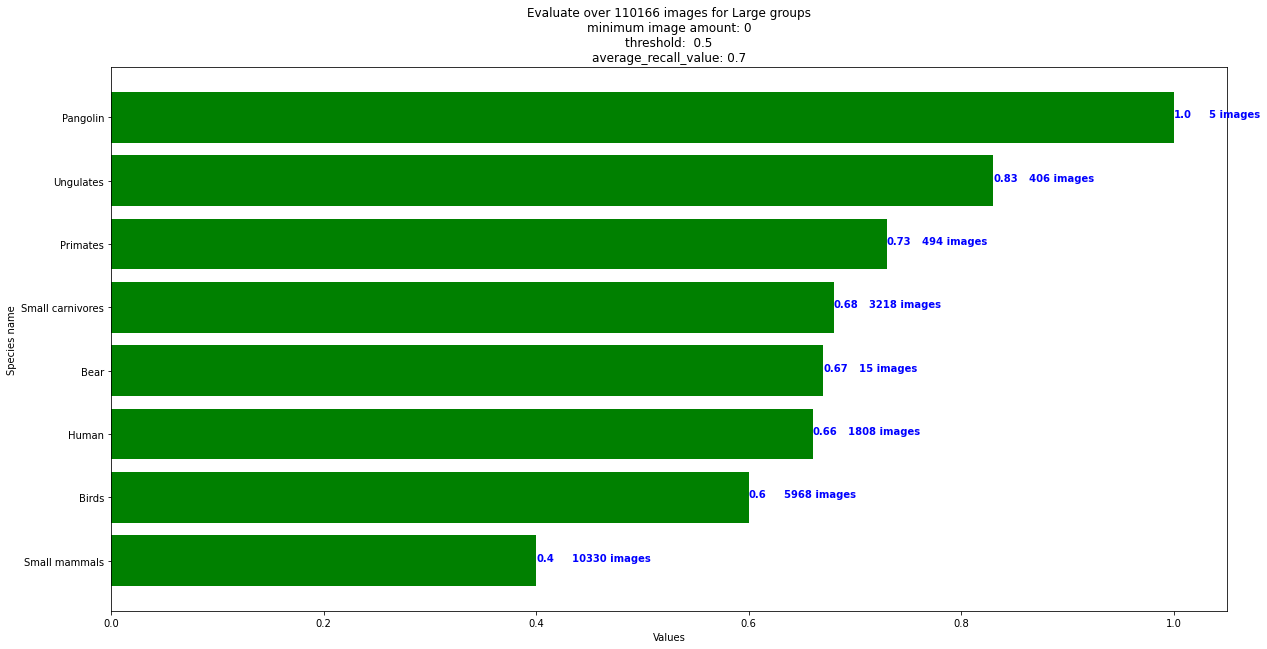

In [74]:
# by large group

confusion_matrix_by_group = \
create_confusion_matrix_by_group(taxon_match_table, confusion_matrix, {'Ungulates'       :['order', 'Cetartiodactyla', []],
                                                                       'Birds'           :['class', 'Aves', []],
                                                                       'Small carnivores':['order', 'Carnivora', ["Asian Black Bear"]],
                                                                       'Small mammals'   :['order', 'Rodentia', []],
                                                                       'Primates'        :['order', 'Primates', ['Human']],
                                                                       'Bear'            :['family', 'Ursidae', []],
                                                                       'Pangolin'        :['family', 'Manidae', []],
                                                                       'Human'           :['species', 'sapiens', []]
                                                                       }) 

colors_large_group = {}
for species in confusion_matrix_by_group.columns:
  colors_large_group[species] = 'green'
visualize_recall_bargraph('Large groups', 
                          confusion_matrix_by_group, 
                          threshold=0.5, 
                          color_dict=colors_large_group, 
                          legend_by_color=False,
                          custom_size=(20,10),
                          save_fig="by independent event/MD_recall_Kon-Plong_big-groups.jpg")

In [75]:
confusion_matrix_by_conservation_status = \
create_confusion_matrix_by_conservation_status(taxon_match_table, 
                                               confusion_matrix, 
                                               ["Endangered", "Vulnerable", "Critically Endangered"])

confusion_matrix_by_conservation_status

,Asian Black Bear,Asian Small-clawed Otter,Chestnut-eared Laughingthrush,Chinese Serow,Crested Argus,Golden-winged Laughingthrush,Grey-shanked Douc Langur,Impressed Tortoise,Northern Pig-tailed Macaque,Owston's Civet,Sambar,Stump-tailed Macaque,Sunda Pangolin
Animal,10.00,8.00,29.00,29.00,100.00,1.0,4.0,2.0,42.00,135.00,4.0,268.00,5.0
Human,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,1.00,0.0,0.00,0.0
Blank,5.00,3.00,15.00,6.00,9.00,0.0,0.0,0.0,3.00,24.00,0.0,94.00,0.0
Total,15.00,11.00,44.00,35.00,109.00,1.0,4.0,2.0,45.00,160.00,4.0,362.00,5.0
Recall,0.67,0.73,0.66,0.83,0.92,1.0,1.0,1.0,0.93,0.84,1.0,0.74,1.0


Generating visualization plot for Vulnerable+ species...
File is saved to by independent event/MD_recall_Kon-Plong_VU-EN-CR.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/MD_recall_Kon-Plong_VU-EN-CR.jpg


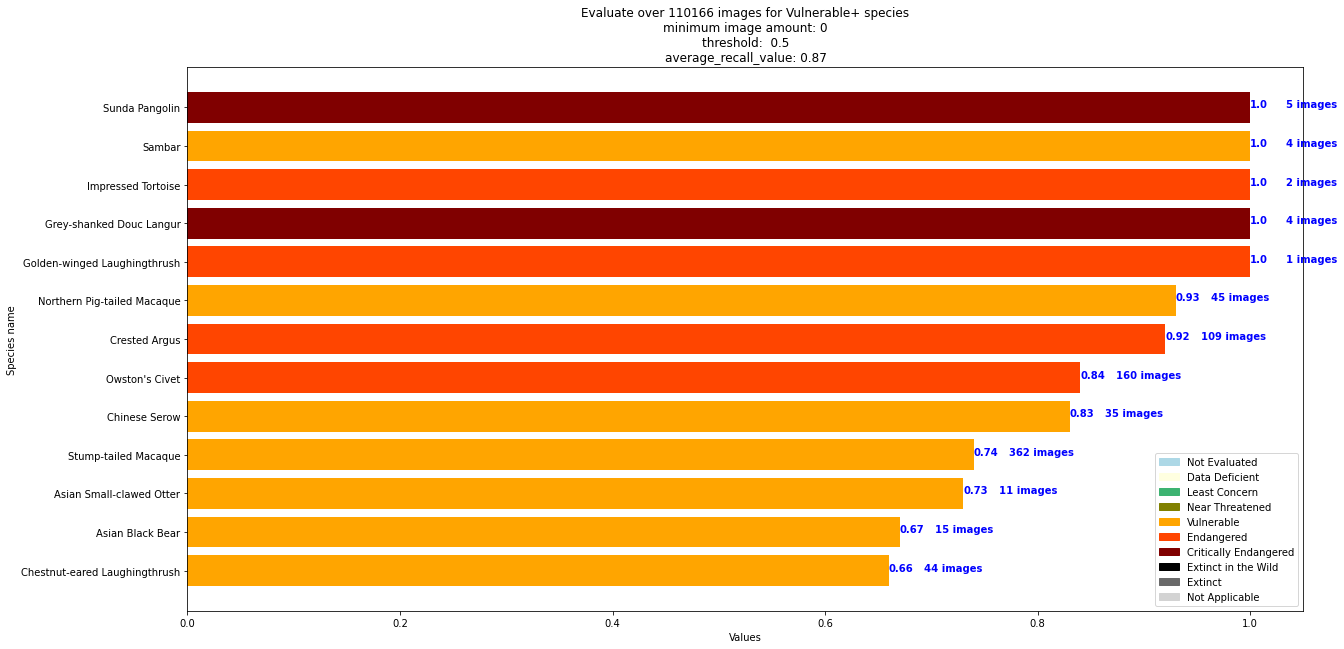

In [76]:
# in rare group
visualize_recall_bargraph('Vulnerable+ species', 
                          confusion_matrix_by_conservation_status, 
                          threshold=0.5, 
                          color_dict = colors, 
                          num_image_threshold=0, 
                          legend_by_color=True, 
                          custom_size=(20,10),
                          save_fig="by independent event/MD_recall_Kon-Plong_VU-EN-CR.jpg")

Generating visualization plot for Ungulates...
File is saved to by independent event/MD_recall_Kon-Plong_in-group_Ungulates.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/MD_recall_Kon-Plong_in-group_Ungulates.jpg


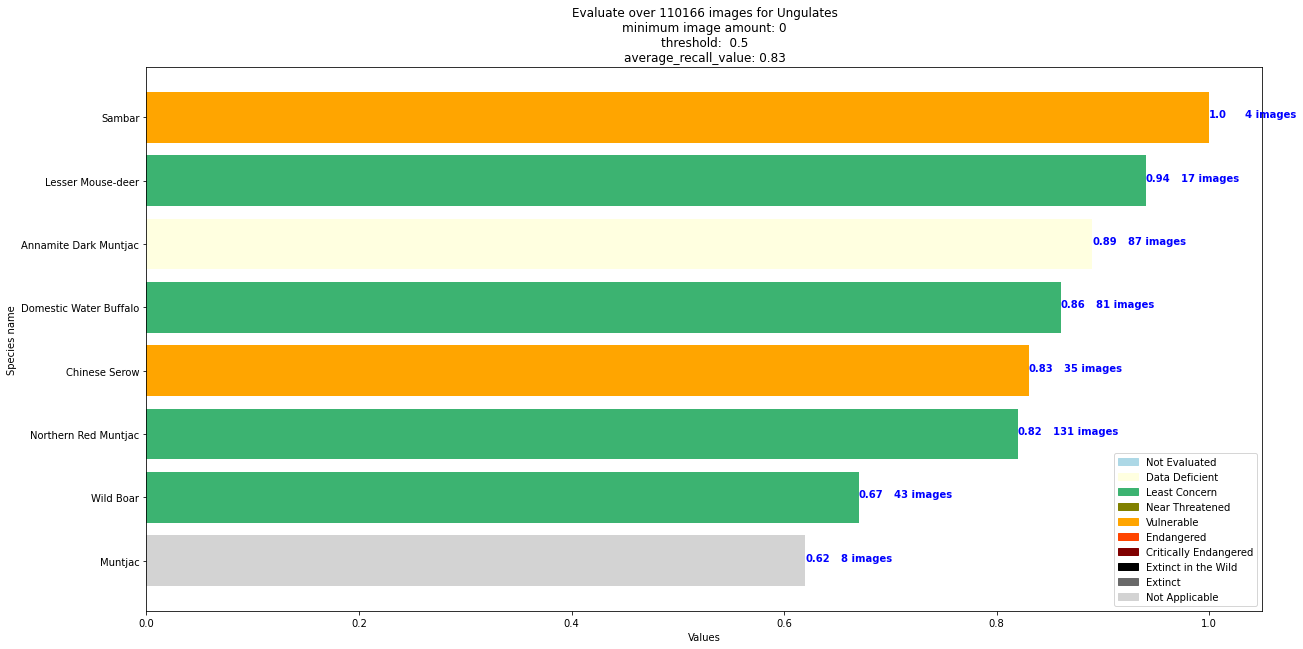

In [77]:
# in Ungulates
confusion_matrix_in_Ungulates_group = create_confusion_matrix_in_group(taxon_match_table, 
                                                                       confusion_matrix, 
                                                                       ['Ungulates', 'order', 'Cetartiodactyla', []])
visualize_recall_bargraph('Ungulates', 
                          confusion_matrix_in_Ungulates_group, 
                          threshold=0.5, 
                          color_dict = colors, 
                          num_image_threshold=0, 
                          legend_by_color=True, 
                          custom_size=(20,10),
                          save_fig="by independent event/MD_recall_Kon-Plong_in-group_Ungulates.jpg")

Generating visualization plot for Birds...
File is saved to by independent event/MD_recall_Kon-Plong_in-group_Birds.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/MD_recall_Kon-Plong_in-group_Birds.jpg


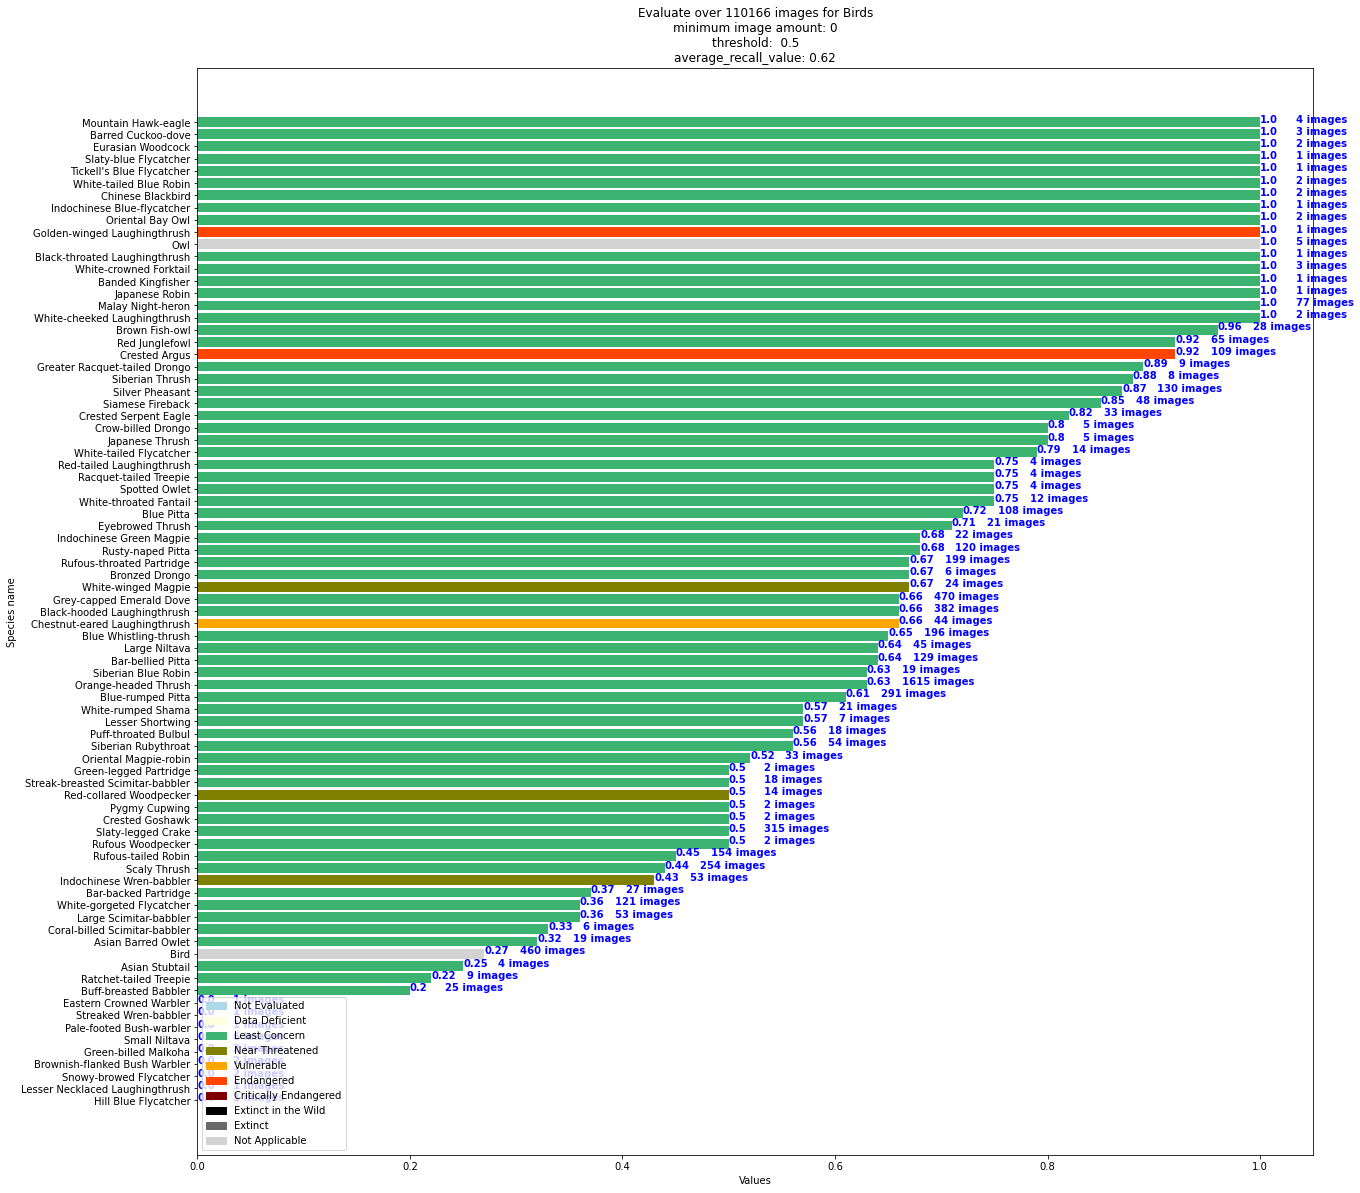

In [78]:
# in Birds
confusion_matrix_in_Birds_group = create_confusion_matrix_in_group(taxon_match_table, confusion_matrix, ['Birds', 'class', 'Aves', []])
visualize_recall_bargraph('Birds', 
                          confusion_matrix_in_Birds_group, 
                          threshold=0.5, 
                          color_dict = colors, 
                          num_image_threshold=0, 
                          legend_by_color=True, 
                          custom_size=(20,20),
                          save_fig="by independent event/MD_recall_Kon-Plong_in-group_Birds.jpg")

Generating visualization plot for Small carnivores...
File is saved to by independent event/MD_recall_Kon-Plong_in-group_Small-carnivores.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/MD_recall_Kon-Plong_in-group_Small-carnivores.jpg


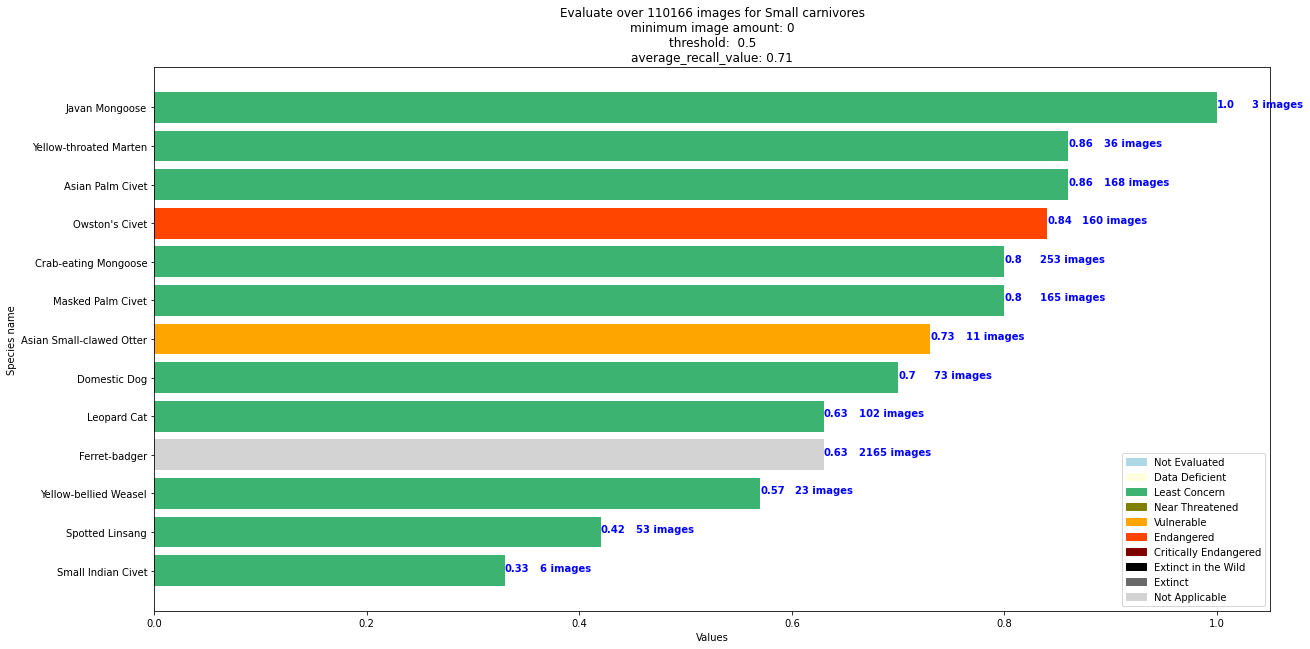

In [79]:
# in Small carnivores
confusion_matrix_in_Small_carnivores_group = create_confusion_matrix_in_group(taxon_match_table, confusion_matrix, ['Small carnivores', 'order', 'Carnivora', ["Asian Black Bear"]])
visualize_recall_bargraph('Small carnivores', 
                          confusion_matrix_in_Small_carnivores_group, 
                          threshold=0.5, 
                          color_dict = colors, 
                          num_image_threshold=0, 
                          legend_by_color=True, 
                          custom_size=(20,10),
                          save_fig="by independent event/MD_recall_Kon-Plong_in-group_Small-carnivores.jpg")

Generating visualization plot for Small mammals...
File is saved to by independent event/MD_recall_Kon-Plong_in-group_Small-mammals.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/MD_recall_Kon-Plong_in-group_Small-mammals.jpg


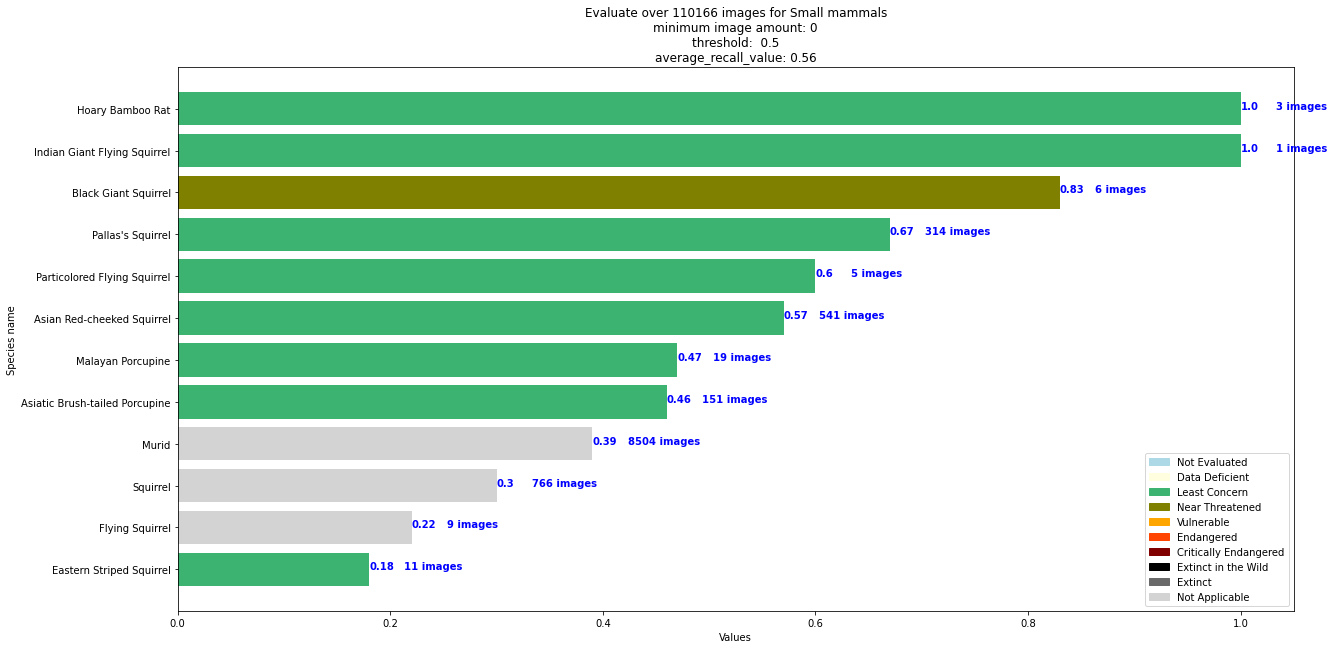

In [80]:
# in Small mammals
confusion_matrix_in_Small_mammal_sgroup = create_confusion_matrix_in_group(taxon_match_table, confusion_matrix, ['Small mammals', 'order', 'Rodentia', []])
visualize_recall_bargraph('Small mammals', 
                          confusion_matrix_in_Small_mammal_sgroup, 
                          threshold=0.5, 
                          color_dict = colors, 
                          num_image_threshold=0, 
                          legend_by_color=True, 
                          custom_size=(20,10),
                          save_fig="by independent event/MD_recall_Kon-Plong_in-group_Small-mammals.jpg")


Generating visualization plot for Primates...
File is saved to by independent event/MD_recall_Kon-Plong_in-group_Primates.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/MD_recall_Kon-Plong_in-group_Primates.jpg


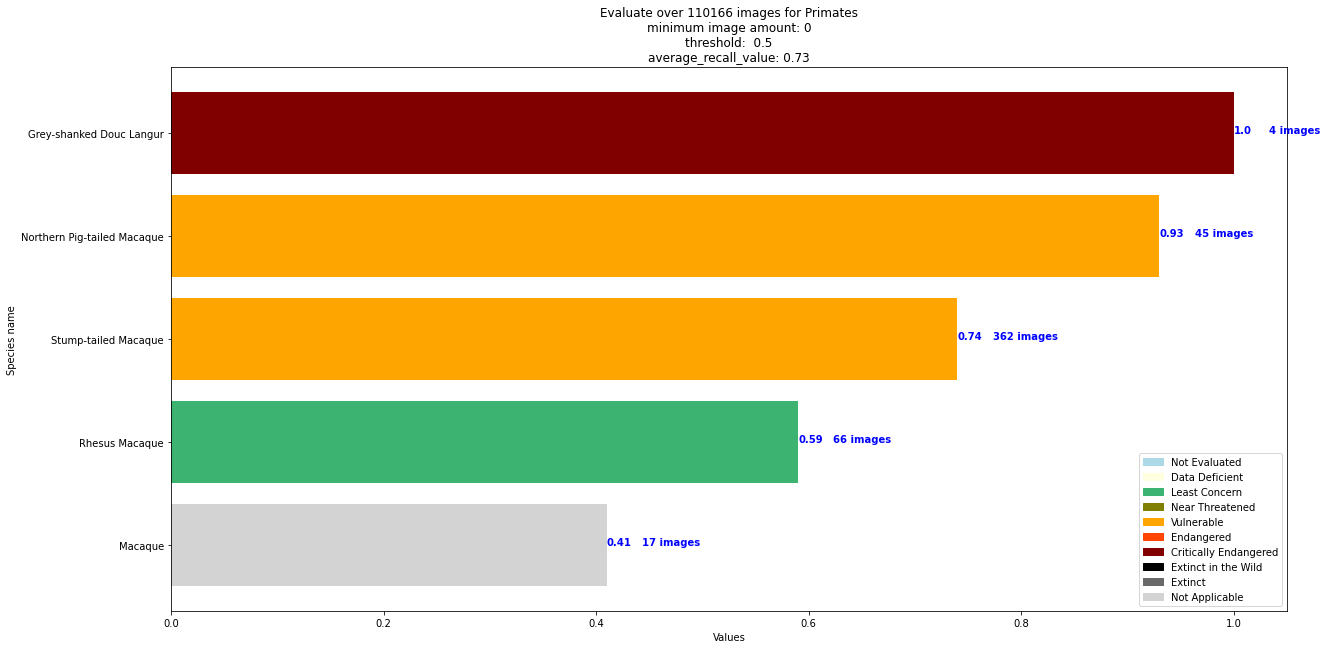

In [81]:
# in Primates
confusion_matrix_in_Primates_group = create_confusion_matrix_in_group(taxon_match_table, confusion_matrix, ['Primates', 'order', 'Primates', ['Human']])
visualize_recall_bargraph('Primates', 
                          confusion_matrix_in_Primates_group, 
                          threshold=0.5, 
                          color_dict = colors, 
                          num_image_threshold=0, 
                          legend_by_color=True, 
                          custom_size=(20,10),
                          save_fig="by independent event/MD_recall_Kon-Plong_in-group_Primates.jpg")

Generating visualization plot for Bear...
File is saved to by independent event/MD_recall_Kon-Plong_in-group_Bear.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/MD_recall_Kon-Plong_in-group_Bear.jpg


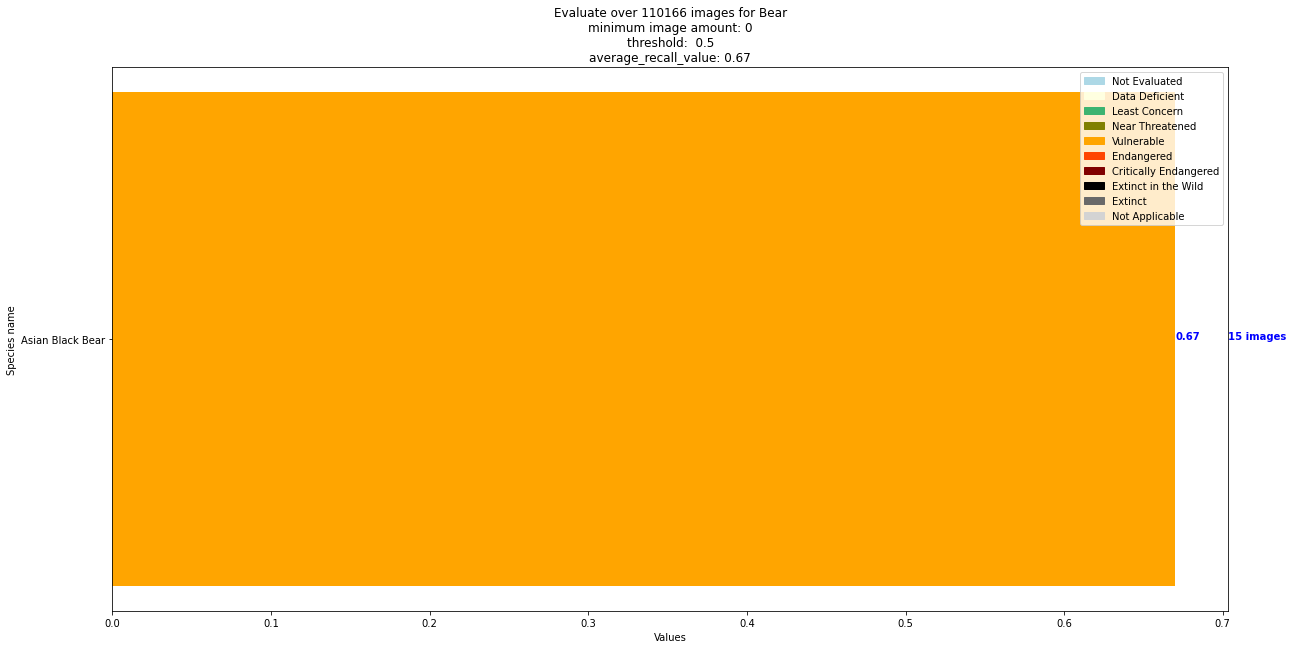

In [82]:
# in Bear
confusion_matrix_in_Bear_group = create_confusion_matrix_in_group(taxon_match_table, confusion_matrix, ['Bear', 'family', 'Ursidae', []])
visualize_recall_bargraph('Bear', 
                          confusion_matrix_in_Bear_group, 
                          threshold=0.5, 
                          color_dict = colors, 
                          num_image_threshold=0, 
                          legend_by_color=True, 
                          custom_size=(20,10),
                          save_fig="by independent event/MD_recall_Kon-Plong_in-group_Bear.jpg")

Generating visualization plot for Pangolin...
File is saved to by independent event/MD_recall_Kon-Plong_in-group_Pangolin.jpg in Google Drive at /content/drive/My Drive/FFI/MegaDetector Test/confusion-matrix/visualization/by independent event/MD_recall_Kon-Plong_in-group_Pangolin.jpg


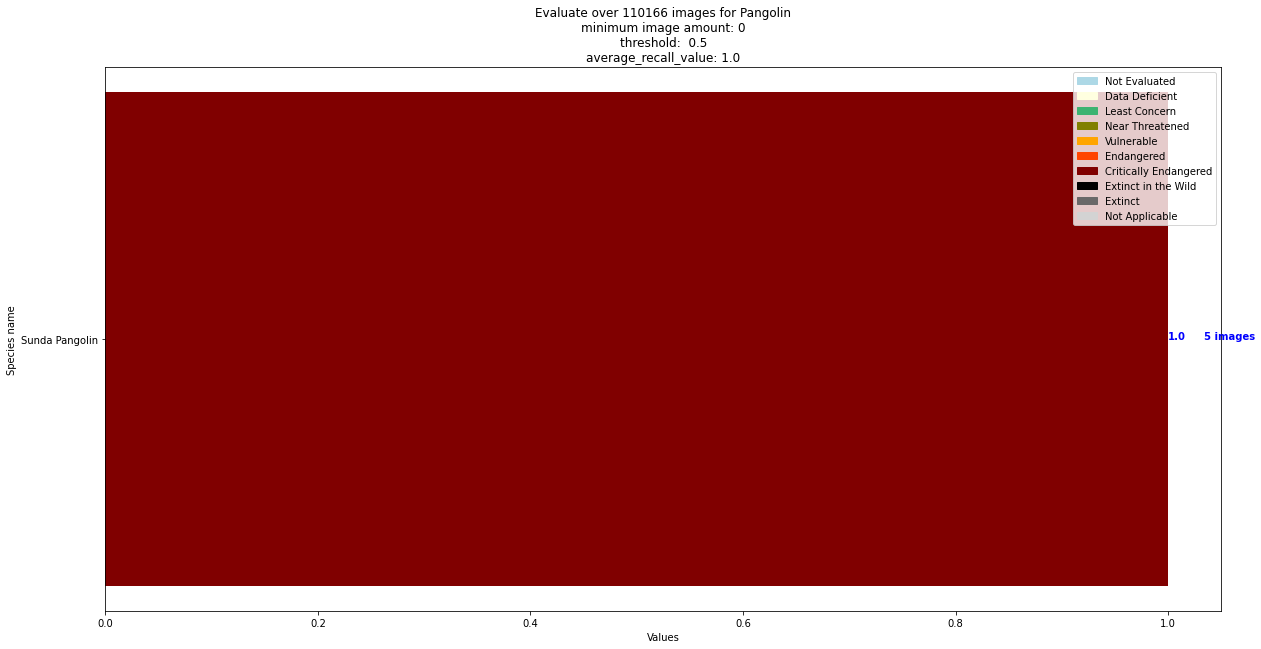

In [83]:
# in Pangolin
confusion_matrix_in_Pangolin_group = create_confusion_matrix_in_group(taxon_match_table, confusion_matrix, ['Pangolin', 'family', 'Manidae', []])
visualize_recall_bargraph('Pangolin', 
                          confusion_matrix_in_Pangolin_group, 
                          threshold=0.5, 
                          color_dict = colors, 
                          num_image_threshold=0, 
                          legend_by_color=True, 
                          custom_size=(20,10),
                          save_fig="by independent event/MD_recall_Kon-Plong_in-group_Pangolin.jpg")